In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 865 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import numpy as np

## Stock to predict

In [ ]:
stock_to_predict = "AAPL"
stock_df =yf.download(stock_to_predict,period="10y")
spy_df = yf.download("SPY",period="10y")
stock_df["SPY"]=spy_df["Close"]
stock_df["intraday_return"] = stock_df["Open"] - stock_df["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Preprocess

In [ ]:
def preprocess_ds(data,day_ago):
     x = []
     y = []
     for i in range(day_ago,len(data)):
          x.append(data[i-day_ago:i]) # historical data: (i-day_ago)~(i-1)
          y.append(data[i,0]) # current observation: i
     return (np.array(x),np.array(y))

In [ ]:
day_ago = 50
feature_lst = ["intraday_return","Close","Volume","SPY"]
num_feature = len(feature_lst)

# Normalization 
feature_normalizer = preprocessing.MinMaxScaler()
normalized_df = feature_normalizer.fit_transform(stock_df[feature_lst])
target_normalizer = preprocessing.MinMaxScaler() # use this to transfer prediction back 
target_normalizer.fit(stock_df[["Close"]]) 

# train-test split
train_split = 0.8
split_pt = math.ceil(len(normalized_df) * train_split)

train_set = normalized_df[:split_pt]
test_set = normalized_df[split_pt:]

train_x , train_y = preprocess_ds(train_set,day_ago=day_ago)
test_x, test_y = preprocess_ds(test_set,day_ago=day_ago)

## LSTM Model building

In [ ]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

keras.backend.clear_session()

model = keras.Sequential()
model.add(layers.LSTM(150,input_shape=(day_ago,num_feature),return_sequences=True))
model.add(layers.LSTM(100))
model.add(layers.Dense(30,activation="relu"))
model.add(layers.Dense(1))

model.compile(loss="mean_squared_error",
          optimizer="adam")

## Model training

In [ ]:
batch_size = 1
epochs = 5
# Train with train set

model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size)

Epoch 1/5
1966/1966 [==============================] - 85s 41ms/step - loss: 0.0012
Epoch 2/5
1966/1966 [==============================] - 83s 42ms/step - loss: 3.0913e-04
Epoch 3/5
1966/1966 [==============================] - 78s 40ms/step - loss: 4.1463e-04
Epoch 4/5
1966/1966 [==============================] - 77s 39ms/step - loss: 2.4969e-04
Epoch 5/5
1966/1966 [==============================] - 78s 40ms/step - loss: 2.1061e-04


## Predict on test set

In [ ]:
pred_y = model.predict(test_x)

15/15 [==============================] - 2s 50ms/step


In [ ]:
pred_train_y = model.predict(train_x)

62/62 [==============================] - 3s 54ms/step


## Visualization

In [ ]:
y_pred_price = target_normalizer.inverse_transform(pred_y)
test_price_original = stock_df["Close"][len(stock_df)-len(y_pred_price):]

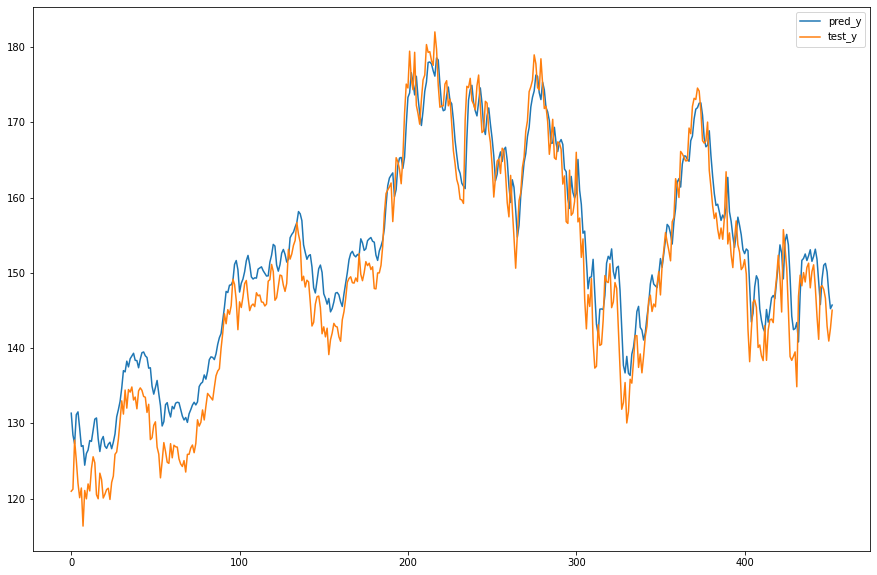

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(y_pred_price,label="pred_y")
plt.plot(list(test_price_original),label="test_y")
plt.legend()
plt.show()

## Trading Strategy

In [ ]:
def buy_sell_call(pred_y,test_y):
  pred_df = pd.DataFrame(data={"original":test_y,"pred":list(pred_y.reshape(1,len(pred_y))[0])})
  pred_df["pred diff"] = pred_df["pred"].diff()
  pred_df["original diff"] = pred_df["original"].diff()
  buy_sell_call = np.zeros(len(pred_df))
  prev_call = 0 

  for i in range(1,len(pred_df)):
    if i == 1:
      buy_sell_call[i] = np.sign(pred_df["pred diff"][i])
      continue
    if np.sign(pred_df["pred diff"][i]) != np.sign(pred_df["pred diff"][i-1]) and prev_call != np.sign(pred_df["pred diff"][i]):
      buy_sell_call[i] = np.sign(pred_df["pred diff"][i])
      prev_call = np.sign(pred_df["pred diff"][i])

  return buy_sell_call

buy_sell_call = buy_sell_call(pred_y,test_y)

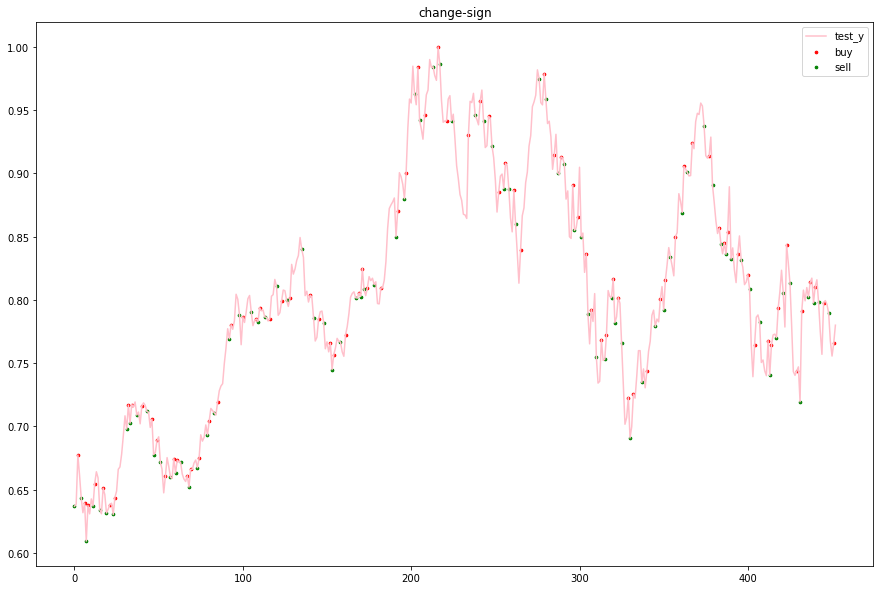

In [ ]:
# diff of prediction at i is the difference between time i and time i-1 (ex.diff at 1 is diff btw t = 1 and t = 0)
# but we make the decision at time i-1 with prediction of i
# need to minus one 
buy_ind = np.where(buy_sell_call==1)[0]-1
sell_ind = np.where(buy_sell_call==-1)[0]-1
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
#plt.plot(pred_y,label="pred_y")
plt.plot(test_y,label="test_y",c="pink")
plt.scatter(buy_ind,test_y[buy_ind],c="r",label="buy",s=7)
plt.scatter(sell_ind,test_y[sell_ind],c="g",label="sell",s=7)
#plt.scatter(buy_ind,pred_y[buy_ind],c="r",label="buy",s=7)
#plt.scatter(sell_ind,pred_y[sell_ind],c="g",label="sell",s=7)

plt.title("change-sign")
plt.legend()
plt.show()

## Calculate Return

In [ ]:
init_money = 100
sum((-buy_sell_call)*test_y)

-0.494591335057155

# ARIMA Model Building

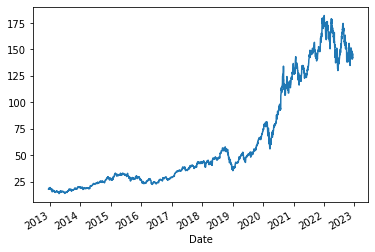

In [ ]:
stock_df['Close'].plot()

In [ ]:
# test for stationarity

from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(stock_df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



ADF Statistic: -0.067203
p-value: 0.952609


In [ ]:
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

new_set = difference(stock_df['Close'])

In [ ]:
new_result = adfuller(new_set)
print('ADF Statistic: %f' % new_result[0])
print('p-value: %f' % new_result[1])

ADF Statistic: -10.532302
p-value: 0.000000


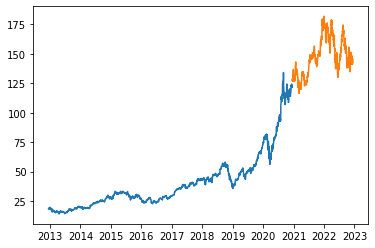

In [ ]:
#split the dataset

train = stock_df[:split_pt]
test = stock_df[split_pt+1:]

plt.plot(train['Close'])
plt.plot(test['Close'])

#train_stationary = new_set[:split_pt]
#test_stationary = new_set[split_pt+1:]

In [ ]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

train_ar = train_stationary
test_ar = test_stationary

history = [x for x in train_ar]
pred = []

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test_ar[t]
    history.append(obs)



In [ ]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

train_ar = train['Close']
test_ar = test['Close']

history = [x for x in train_ar]
pred = []

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test_ar[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test_ar, pred)
RMSE = np.sqrt(error)
print('Testing Root Mean Squared Error: %.3f' % RMSE)

Testing Root Mean Squared Error: 2.894


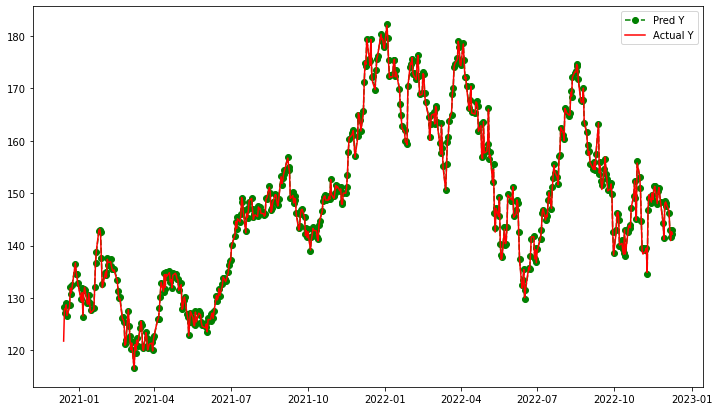

In [ ]:
new_pred = test['Close'][1:]+pred


plt.figure(figsize=(12,7))
plt.plot(new_pred, color='green', marker='o', linestyle='dashed', 
         label='Pred Y')
plt.plot(test['Close'], color='red', label='Actual Y')
plt.legend()

#Neural Prophet

In [ ]:
pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 7.5 MB/s 
     |████████████████████████████████| 1.6 MB 19.2 MB/s 


In [ ]:
from neuralprophet import NeuralProphet

new_df = stock_df.reset_index()
new_df = new_df[['Date','Close']]
new_df.rename(columns={'Date':'ds','Close':'y'},inplace=True)

Model Training

In [ ]:
prophet_model = NeuralProphet(
    n_forecasts=10,
    n_lags=20,
    n_changepoints=25,
    epochs=100,
    learning_rate=0.5)


In [ ]:

new_train = new_df[:split_pt]
new_test = new_df[split_pt+1:]

prophet_model.fit(new_train,freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.326% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.326% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 909 missing dates added.
INFO:NP.forecaster:909 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 909 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 909 NaN values in column y were auto-imputed.
INFO:NP.forecaster:909 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet w

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,0.211076,39.326815,51.191310,0.177229,0.0
1,0.024822,14.761373,17.931820,0.017635,0.0
2,0.012717,10.270481,12.721714,0.008900,0.0
3,0.004484,5.930291,7.508263,0.003320,0.0
4,0.001874,3.688830,4.900317,0.001568,0.0
...,...,...,...,...,...
95,0.000269,1.127138,1.804637,0.000250,0.0
96,0.000241,1.046355,1.714736,0.000225,0.0
97,0.000236,1.037661,1.687792,0.000221,0.0
98,0.000231,1.004746,1.669248,0.000217,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.215% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.215% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.289% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.289% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 226 missing dates added.
INFO:NP.forecaster:226 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 226 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 226 NaN values in column y were auto-imputed.
INFO:NP.forecaster:226 NaN values in colu

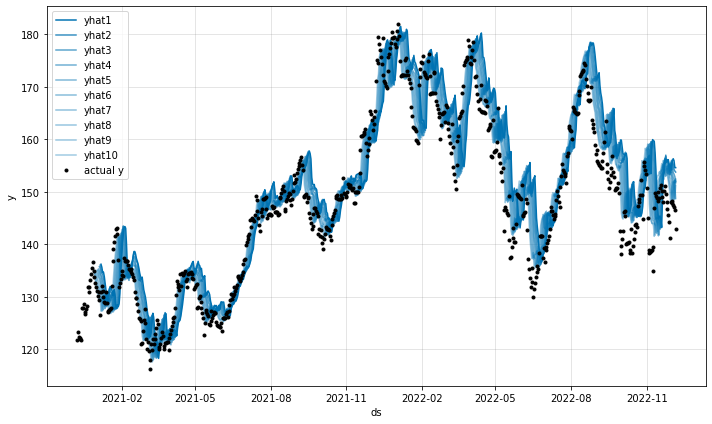

In [ ]:
prediction = prophet_model.predict(new_test)

forecast = prophet_model.plot(prediction)
plt.show()

RL-LSTM

In [ ]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 gym-anytrading gym stable-baselines


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 7.3 kB/s 
     |████████████████████████████████| 412.3 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 46.0 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 503 kB 48.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f6e4d171f27cf785c1111a826fb3c1d25e5dd3232ef3b8471a2c537153ea735a
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
     

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documen

In [ ]:
!pip install gym-anytrading gym


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
stock_df.index = pd.to_datetime(stock_df.index)
stock_df = stock_df.drop('Adj Close',axis=1)
stock_df.sort_index()
stock_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-12-05,42.264999,42.880001,42.099998,42.410000,109400800
2017-12-06,41.875000,42.549999,41.615002,42.252499,114240000
2017-12-07,42.257500,42.610001,42.227501,42.330002,102693200
2017-12-08,42.622501,42.750000,42.205002,42.342499,93420800
2017-12-11,42.299999,43.222500,42.197498,43.167500,141095200


In [ ]:
import gym
import gym_anytrading

# setting up stocks environment, with the first 100 timestamp starting from the 
# 5th one. window_size is the data that the algorithm has as reference data.

env = gym.make('stocks-v0', df=stock_df.sort_index(), frame_bound=(5,100), window_size=5)
env.prices

array([42.36999893, 42.96250153, 42.76250076, 42.45000076, 42.40999985,
       42.25249863, 42.33000183, 42.34249878, 43.16749954, 42.92499924,
       43.06750107, 43.05500031, 43.49250031, 44.10499954, 43.63499832,
       43.58750153, 43.75249863, 43.75249863, 42.64250183, 42.65000153,
       42.77000046, 42.30749893, 43.06499863, 43.05749893, 43.25749969,
       43.75      , 43.58750153, 43.58250046, 43.57249832, 43.81999969,
       44.27249908, 44.04750061, 44.77500153, 44.81499863, 44.61500168,
       44.25      , 44.25999832, 43.55500031, 42.77750015, 42.87749863,
       41.99000168, 41.74250031, 41.85749817, 41.94499969, 40.125     ,
       39.12250137, 40.75749969, 39.88499832, 38.78749847, 39.10250092,
       40.67750168, 41.08499908, 41.84249878, 43.24750137, 43.10749817,
       42.96250153, 42.76750183, 43.125     , 43.875     , 44.74250031,
       44.59749985, 44.52999878, 43.75      , 44.05250168, 44.20500183,
       44.16749954, 43.75749969, 44.23500061, 44.99499893, 45.43

Building Environment

Actions: Sell = 0, Buy = 1 // [0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]
info {'total_reward': -1.9750022888183594, 'total_profit': 0.6567773230809235, 'position': 0}
Taking a bunch of random steps will leave us total_profit*100% in the end


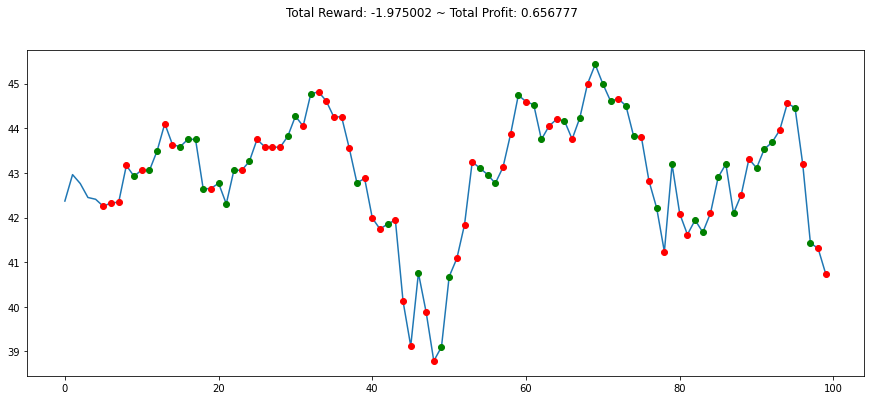

In [ ]:
state = env.reset()
actions = []

while True:
  action = env.action_space.sample()
  n_state, reward, done, info = env.step(action) # passing through the buy/sell action to our env
  actions.append(action)
  if done:
    print(f'Actions: Sell = 0, Buy = 1 // {actions}')
    print('info',info)
    print('Taking a bunch of random steps will leave us total_profit*100% in the end')
    break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Training

In [ ]:
setup = lambda : gym.make('stocks-v0', df=stock_df.sort_index(), frame_bound=(5,100), window_size=5)
env = DummyVecEnv([setup])

In [ ]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

---------------------------------
| explained_variance | -0.02    |
| fps                | 24       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 0.422    |
---------------------------------
---------------------------------
| explained_variance | -0.0224  |
| fps                | 414      |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | 0.0657   |
| fps                | 453      |
| nupdates           | 200      |
| policy_entropy     | 0.692    |
| total_timesteps    | 1000     |
| value_loss         | 0.0172   |
---------------------------------
---------------------------------
| explained_variance | -0.00328 |
| fps                | 469      |
| nupdates           | 300      |
| policy_entropy     | 0.693    |
| total_timest

Evaluate

In [ ]:
new_env = gym.make('stocks-v0', df=stock_df.sort_index(), frame_bound=(80,110), window_size=5)
obs = new_env.reset()

while True:
  obs = obs[np.newaxis, ...]
  action, _states = model.predict(obs)
  obs,rewards,done,info = new_env.step(action)
  if done:
    print('info',info)
    break

info {'total_reward': 0.18249893188476562, 'total_profit': 0.9048470915891911, 'position': 0}


In [ ]:
action.shape

()